We are going to work on the Fashion MNIST dataset, a multiclass classification problem

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"{torch.__version__}, {torchvision.__version__}")

2.4.0+rocm6.1, 0.19.0+rocm6.1


In [4]:
train = datasets.FashionMNIST("./datasets", True, ToTensor(), download=True)
test = datasets.FashionMNIST("./datasets", False, ToTensor(), download=True)

In [8]:
a, b = train[0]
a.shape, b

(torch.Size([1, 28, 28]), 9)

To get the classes

In [92]:
objects = tuple(test.classes)
objects

('T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot')

If we want to see a random image

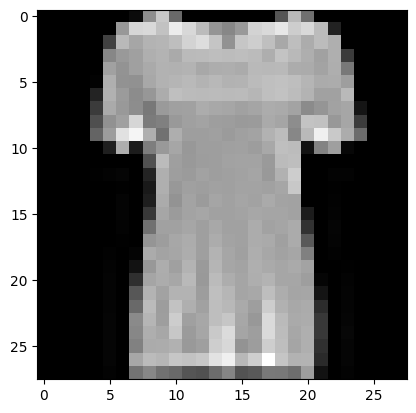

In [12]:
image, label = train[10]
plt.imshow(image.squeeze(), cmap="gray")

Lets try a mini-batch training with the DataLoader from pytorch

In [13]:
from torch.utils.data import DataLoader

train_data = DataLoader(train, batch_size=64, shuffle=True)
test_data = DataLoader(test, batch_size=64, shuffle=True)

In [14]:
len(train_data), len(test_data)

(938, 157)

Of 64 batches giving

In [15]:

len(train_data) * 64, len(test_data) * 64

(60032, 10048)

If we want to see how its every batch

In [19]:
features, label = next(iter(train_data))
features.shape, label.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

Lets introduce the nn.Flatten(), to squeeze matrix in a single vector

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
class FashionModelV1(nn.Module):
    def __init__(self, input_shape, output_shape,hidden_layers = 20, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sequence_layer = nn.Sequential(
            nn.Flatten(), #To first of all flaten the vector
            nn.Linear(input_shape, hidden_layers),
            nn.Linear(hidden_layers, output_shape)
        )
    def forward(self, x:torch.Tensor):
        return self.sequence_layer(x)

So, we know that the input shape is 28*28 = 784, te output is 10 because of the 10 classes

In [24]:
model_1 = FashionModelV1(784, len(train.classes)).to(device)
model_1

FashionModelV1(
  (sequence_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [130]:
from torchmetrics import Accuracy

accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss() #Remeber to use in multiclass problems
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

Now the training

In [43]:

def train_func(model: torch.nn.Module, data: torch.utils.data.DataLoader, loss_fn: torch.nn.Module
               , optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(data):
        model.train()
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(1), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss /= len(data)
        train_acc /= len(data)
        print(f"Train loss: {train_loss: .5f} | Train accuracy {train_acc * 100: .5f}")

def test_func(model: torch.nn.Module, data: torch.utils.data.DataLoader, loss_fn: torch.nn.Module
               , optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device = device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in data:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(1), y)
            test_loss /= len(data)
            test_acc /= len(data)
            print(f"Train loss: {test_loss: .5f} | Train accuracy {test_acc * 100: .5f}")

In [36]:
from tqdm.auto import tqdm

torch.manual_seed(23)

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch + 1}------\n")
    train_func(model_1,train_data,loss_fn,optimizer,accuracy)
    test_func(model_1,train_data,loss_fn,optimizer,accuracy)


  0%|          | 0/10 [00:00<?, ?it/s]

0------

Train loss:  0.00083 | Train accuracy  0.07496
Train loss:  0.00056 | Train accuracy  0.08670
Train loss:  0.00060 | Train accuracy  0.08172
Train loss:  0.00035 | Train accuracy  0.09504
Train loss:  0.00038 | Train accuracy  0.09338
Train loss:  0.00052 | Train accuracy  0.08839
Train loss:  0.00080 | Train accuracy  0.08338
Train loss:  0.00065 | Train accuracy  0.08005
Train loss:  0.00042 | Train accuracy  0.09670
Train loss:  0.00039 | Train accuracy  0.09339
Train loss:  0.00048 | Train accuracy  0.08505
Train loss:  0.00041 | Train accuracy  0.09171
Train loss:  0.00073 | Train accuracy  0.08006
Train loss:  0.00069 | Train accuracy  0.08671
Train loss:  0.00037 | Train accuracy  0.09671
Train loss:  0.00043 | Train accuracy  0.09006
Train loss:  0.00031 | Train accuracy  0.09505
Train loss:  0.00041 | Train accuracy  0.09338
Train loss:  0.00055 | Train accuracy  0.08672
Train loss:  0.00063 | Train accuracy  0.08005
Train loss:  0.00071 | Train accuracy  0.08671
Trai

 10%|█         | 1/10 [00:08<01:17,  8.59s/it]

Train loss:  0.00053 | Train accuracy  0.08837
Train loss:  0.00043 | Train accuracy  0.09171
Train loss:  0.00067 | Train accuracy  0.07672
Train loss:  0.00056 | Train accuracy  0.08670
Train loss:  0.00052 | Train accuracy  0.08671
Train loss:  0.00049 | Train accuracy  0.09171
Train loss:  0.00061 | Train accuracy  0.08838
Train loss:  0.00043 | Train accuracy  0.09338
Train loss:  0.00061 | Train accuracy  0.08672
Train loss:  0.00067 | Train accuracy  0.07838
Train loss:  0.00069 | Train accuracy  0.08670
Train loss:  0.00048 | Train accuracy  0.08505
Train loss:  0.00059 | Train accuracy  0.08671
Train loss:  0.00057 | Train accuracy  0.08671
Train loss:  0.00045 | Train accuracy  0.09004
Train loss:  0.00032 | Train accuracy  0.10004
1------

Train loss:  0.00064 | Train accuracy  0.08662
Train loss:  0.00063 | Train accuracy  0.08671
Train loss:  0.00038 | Train accuracy  0.09171
Train loss:  0.00053 | Train accuracy  0.08838
Train loss:  0.00064 | Train accuracy  0.09005
Trai

 20%|██        | 2/10 [00:16<01:07,  8.42s/it]

Train loss:  0.00046 | Train accuracy  0.08671
Train loss:  0.00066 | Train accuracy  0.07672
Train loss:  0.00054 | Train accuracy  0.08170
Train loss:  0.00040 | Train accuracy  0.09337
Train loss:  0.00048 | Train accuracy  0.09172
Train loss:  0.00038 | Train accuracy  0.09338
Train loss:  0.00041 | Train accuracy  0.09172
Train loss:  0.00048 | Train accuracy  0.08838
Train loss:  0.00044 | Train accuracy  0.09171
Train loss:  0.00061 | Train accuracy  0.08672
Train loss:  0.00043 | Train accuracy  0.08838
Train loss:  0.00068 | Train accuracy  0.08172
Train loss:  0.00066 | Train accuracy  0.08671
Train loss:  0.00068 | Train accuracy  0.08505
Train loss:  0.00052 | Train accuracy  0.08505
Train loss:  0.00053 | Train accuracy  0.08671
Train loss:  0.00047 | Train accuracy  0.09004
Train loss:  0.00046 | Train accuracy  0.09671
2------

Train loss:  0.00085 | Train accuracy  0.08829
Train loss:  0.00053 | Train accuracy  0.08838
Train loss:  0.00059 | Train accuracy  0.09171
Trai

 30%|███       | 3/10 [00:25<00:58,  8.40s/it]

Train loss:  0.00054 | Train accuracy  0.08006
Train loss:  0.00043 | Train accuracy  0.09670
Train loss:  0.00033 | Train accuracy  0.09672
Train loss:  0.00054 | Train accuracy  0.09172
Train loss:  0.00038 | Train accuracy  0.09172
Train loss:  0.00034 | Train accuracy  0.09338
Train loss:  0.00043 | Train accuracy  0.09005
Train loss:  0.00045 | Train accuracy  0.08005
Train loss:  0.00041 | Train accuracy  0.09170
Train loss:  0.00073 | Train accuracy  0.08339
Train loss:  0.00079 | Train accuracy  0.08338
Train loss:  0.00026 | Train accuracy  0.10337
Train loss:  0.00047 | Train accuracy  0.09006
Train loss:  0.00096 | Train accuracy  0.08005
Train loss:  0.00039 | Train accuracy  0.09004
Train loss:  0.00045 | Train accuracy  0.08838
Train loss:  0.00047 | Train accuracy  0.08505
Train loss:  0.00055 | Train accuracy  0.08171
Train loss:  0.00050 | Train accuracy  0.09337
Train loss:  0.00052 | Train accuracy  0.09338
Train loss:  0.00051 | Train accuracy  0.09172
Train loss:  

 40%|████      | 4/10 [00:33<00:50,  8.45s/it]

Train loss:  0.00048 | Train accuracy  0.09337
Train loss:  0.00109 | Train accuracy  0.07673
Train loss:  0.00083 | Train accuracy  0.08170
Train loss:  0.00046 | Train accuracy  0.08837
Train loss:  0.00062 | Train accuracy  0.08338
Train loss:  0.00045 | Train accuracy  0.09171
Train loss:  0.00079 | Train accuracy  0.08172
Train loss:  0.00042 | Train accuracy  0.09170
Train loss:  0.00076 | Train accuracy  0.07839
Train loss:  0.00050 | Train accuracy  0.08670
Train loss:  0.00036 | Train accuracy  0.09171
Train loss:  0.00046 | Train accuracy  0.08672
Train loss:  0.00043 | Train accuracy  0.09171
Train loss:  0.00049 | Train accuracy  0.08838
Train loss:  0.00073 | Train accuracy  0.08671
Train loss:  0.00062 | Train accuracy  0.08172
Train loss:  0.00059 | Train accuracy  0.08504
Train loss:  0.00046 | Train accuracy  0.08171
Train loss:  0.00088 | Train accuracy  0.07505
Train loss:  0.00067 | Train accuracy  0.08337
Train loss:  0.00081 | Train accuracy  0.08671
Train loss:  

 50%|█████     | 5/10 [00:42<00:42,  8.53s/it]

Train loss:  0.00044 | Train accuracy  0.08504
Train loss:  0.00049 | Train accuracy  0.08338
Train loss:  0.00075 | Train accuracy  0.08338
Train loss:  0.00048 | Train accuracy  0.09004
Train loss:  0.00039 | Train accuracy  0.08672
Train loss:  0.00058 | Train accuracy  0.08671
Train loss:  0.00040 | Train accuracy  0.09004
Train loss:  0.00061 | Train accuracy  0.08672
Train loss:  0.00060 | Train accuracy  0.08671
Train loss:  0.00050 | Train accuracy  0.08838
Train loss:  0.00079 | Train accuracy  0.09005
Train loss:  0.00059 | Train accuracy  0.08838
Train loss:  0.00083 | Train accuracy  0.08338
Train loss:  0.00071 | Train accuracy  0.08671
Train loss:  0.00038 | Train accuracy  0.09338
Train loss:  0.00064 | Train accuracy  0.08839
Train loss:  0.00066 | Train accuracy  0.08505
Train loss:  0.00041 | Train accuracy  0.09171
Train loss:  0.00067 | Train accuracy  0.08006
Train loss:  0.00078 | Train accuracy  0.08337
Train loss:  0.00067 | Train accuracy  0.08338
5------

Trai

 60%|██████    | 6/10 [00:51<00:34,  8.56s/it]

Train loss:  0.00042 | Train accuracy  0.09171
Train loss:  0.00047 | Train accuracy  0.08838
Train loss:  0.00056 | Train accuracy  0.08838
Train loss:  0.00033 | Train accuracy  0.09671
Train loss:  0.00054 | Train accuracy  0.08672
Train loss:  0.00046 | Train accuracy  0.08671
Train loss:  0.00024 | Train accuracy  0.10004
Train loss:  0.00066 | Train accuracy  0.08340
Train loss:  0.00051 | Train accuracy  0.09504
Train loss:  0.00042 | Train accuracy  0.09005
Train loss:  0.00038 | Train accuracy  0.09338
Train loss:  0.00051 | Train accuracy  0.08672
Train loss:  0.00046 | Train accuracy  0.08838
Train loss:  0.00046 | Train accuracy  0.09338
Train loss:  0.00050 | Train accuracy  0.09172
Train loss:  0.00037 | Train accuracy  0.09671
Train loss:  0.00030 | Train accuracy  0.09672
Train loss:  0.00053 | Train accuracy  0.09172
Train loss:  0.00044 | Train accuracy  0.09338
Train loss:  0.00053 | Train accuracy  0.08672
Train loss:  0.00043 | Train accuracy  0.09171
Train loss:  

 70%|███████   | 7/10 [00:59<00:25,  8.50s/it]

Train loss:  0.00038 | Train accuracy  0.09338
Train loss:  0.00066 | Train accuracy  0.09172
Train loss:  0.00079 | Train accuracy  0.08172
Train loss:  0.00028 | Train accuracy  0.09670
Train loss:  0.00075 | Train accuracy  0.08672
Train loss:  0.00033 | Train accuracy  0.09338
Train loss:  0.00064 | Train accuracy  0.08006
Train loss:  0.00048 | Train accuracy  0.08671
Train loss:  0.00077 | Train accuracy  0.08505
Train loss:  0.00024 | Train accuracy  0.09671
7------

Train loss:  0.00071 | Train accuracy  0.08162
Train loss:  0.00042 | Train accuracy  0.09504
Train loss:  0.00058 | Train accuracy  0.08839
Train loss:  0.00042 | Train accuracy  0.09171
Train loss:  0.00042 | Train accuracy  0.08672
Train loss:  0.00036 | Train accuracy  0.09338
Train loss:  0.00040 | Train accuracy  0.09505
Train loss:  0.00036 | Train accuracy  0.09338
Train loss:  0.00029 | Train accuracy  0.09671
Train loss:  0.00038 | Train accuracy  0.08839
Train loss:  0.00049 | Train accuracy  0.09005
Trai

 80%|████████  | 8/10 [01:07<00:16,  8.43s/it]

Train loss:  0.00044 | Train accuracy  0.09005
Train loss:  0.00054 | Train accuracy  0.08672
Train loss:  0.00031 | Train accuracy  0.09338
Train loss:  0.00041 | Train accuracy  0.09005
8------

Train loss:  0.00031 | Train accuracy  0.09495
Train loss:  0.00038 | Train accuracy  0.09338
Train loss:  0.00051 | Train accuracy  0.08672
Train loss:  0.00036 | Train accuracy  0.09504
Train loss:  0.00064 | Train accuracy  0.08506
Train loss:  0.00041 | Train accuracy  0.09504
Train loss:  0.00040 | Train accuracy  0.09005
Train loss:  0.00044 | Train accuracy  0.09171
Train loss:  0.00039 | Train accuracy  0.08672
Train loss:  0.00034 | Train accuracy  0.09004
Train loss:  0.00030 | Train accuracy  0.09338
Train loss:  0.00041 | Train accuracy  0.09172
Train loss:  0.00036 | Train accuracy  0.09172
Train loss:  0.00043 | Train accuracy  0.08672
Train loss:  0.00066 | Train accuracy  0.07838
Train loss:  0.00043 | Train accuracy  0.08504
Train loss:  0.00035 | Train accuracy  0.09671
Trai

 90%|█████████ | 9/10 [01:16<00:08,  8.45s/it]

Train loss:  0.00058 | Train accuracy  0.08671
Train loss:  0.00056 | Train accuracy  0.08005
Train loss:  0.00035 | Train accuracy  0.09337
Train loss:  0.00055 | Train accuracy  0.08839
Train loss:  0.00045 | Train accuracy  0.09005
Train loss:  0.00040 | Train accuracy  0.08672
Train loss:  0.00052 | Train accuracy  0.08505
Train loss:  0.00056 | Train accuracy  0.08671
Train loss:  0.00045 | Train accuracy  0.09338
Train loss:  0.00051 | Train accuracy  0.09005
Train loss:  0.00057 | Train accuracy  0.08338
Train loss:  0.00072 | Train accuracy  0.08338
Train loss:  0.00050 | Train accuracy  0.08504
Train loss:  0.00051 | Train accuracy  0.08505
Train loss:  0.00052 | Train accuracy  0.08838
Train loss:  0.00050 | Train accuracy  0.09005
Train loss:  0.00052 | Train accuracy  0.09005
Train loss:  0.00062 | Train accuracy  0.08338
Train loss:  0.00064 | Train accuracy  0.08005
Train loss:  0.00049 | Train accuracy  0.09170
Train loss:  0.00056 | Train accuracy  0.08339
Train loss:  

100%|██████████| 10/10 [01:24<00:00,  8.47s/it]

Train loss:  0.00044 | Train accuracy  0.09172
Train loss:  0.00044 | Train accuracy  0.09338
Train loss:  0.00036 | Train accuracy  0.09005
Train loss:  0.00060 | Train accuracy  0.08838
Train loss:  0.00027 | Train accuracy  0.09504
Train loss:  0.00052 | Train accuracy  0.08506
Train loss:  0.00067 | Train accuracy  0.08671
Train loss:  0.00064 | Train accuracy  0.08671
Train loss:  0.00047 | Train accuracy  0.09338
Train loss:  0.00059 | Train accuracy  0.09005
Train loss:  0.00038 | Train accuracy  0.09338
Train loss:  0.00060 | Train accuracy  0.08505
Train loss:  0.00028 | Train accuracy  0.09837
Train loss:  0.00039 | Train accuracy  0.09505
Train loss:  0.00073 | Train accuracy  0.08006
Train loss:  0.00035 | Train accuracy  0.09503
Train loss:  0.00037 | Train accuracy  0.09172
Train loss:  0.00047 | Train accuracy  0.09005
Train loss:  0.00023 | Train accuracy  0.09838
Train loss:  0.00067 | Train accuracy  0.08506
Train loss:  0.00047 | Train accuracy  0.08671
Train loss:  

In [48]:
def eval_model(model: torch.nn.Module, data: torch.utils.data.DataLoader, loss_fn: torch.nn.Module
               , accuracy_fn, device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(1), y)
            loss /= len(data)
            acc /= len(data)
            return{
                "model_name": model.__class__.__name__,
                "model_loss": loss.item(),
                "model_acc": acc * 100
            }

In [49]:
eval_model(model_1, test_data, loss_fn, accuracy)

{'model_name': 'FashionModelV1',
 'model_loss': 0.0021651999559253454,
 'model_acc': tensor(0.5772, device='cuda:0')}

In [110]:
X, y = test.data.type(torch.float).to(device), test.targets.to(device)
with torch.inference_mode():
    y_logits = model_1(X)
    y_pred = torch.softmax(y_logits, 1).argmax(1)

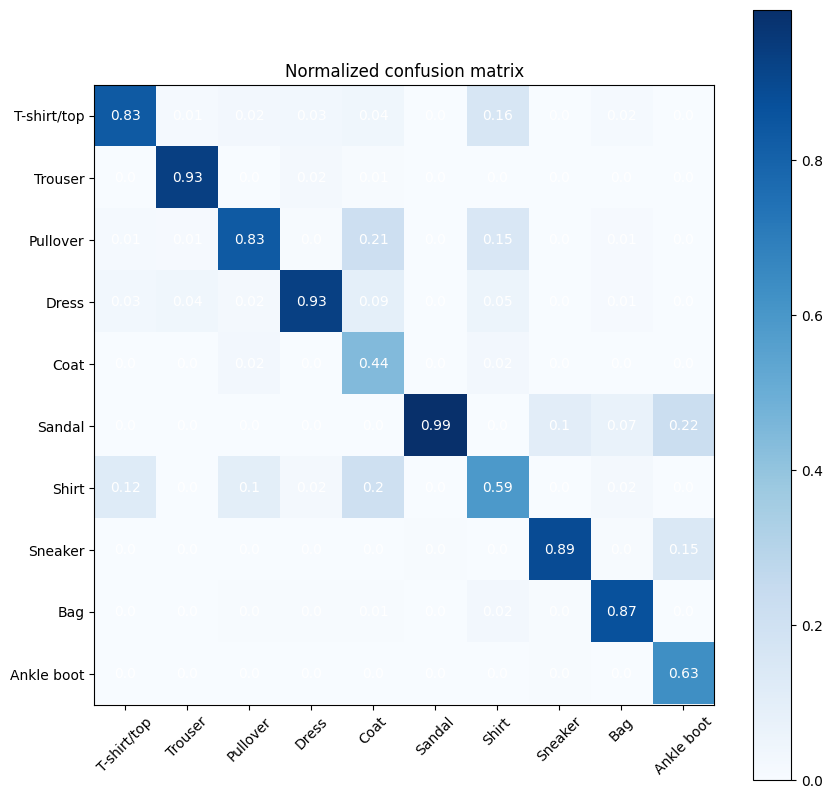

In [111]:
from sklearn.metrics import confusion_matrix
import numpy as np
cm = confusion_matrix(y.to("cpu").detach().numpy(), y_pred.to("cpu").detach().numpy())
cm = cm / np.sum(cm,axis=0) # to normalize
cmap = plt.cm.Blues
tick_marks = np.arange(10)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, np.around(cm[i, j],decimals=2),
                       ha="center", va="center", color="w")
plt.title('Normalized confusion matrix')
fig.colorbar(im)
plt.xticks(tick_marks, objects, rotation=45)
plt.yticks(tick_marks, objects);


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)
cm = cm / np.sum(cm,axis=0) # to normalize
cmap = plt.cm.Blues
tick_marks = np.arange(nb_classes)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, np.around(cm[i, j],decimals=2),
                       ha="center", va="center", color="w")
plt.title('Normalized confusion matrix')
fig.colorbar(im)
plt.xticks(tick_marks, objects, rotation=45)
plt.yticks(tick_marks, objects)

Lets do a CNN or Convolutional Neural Network

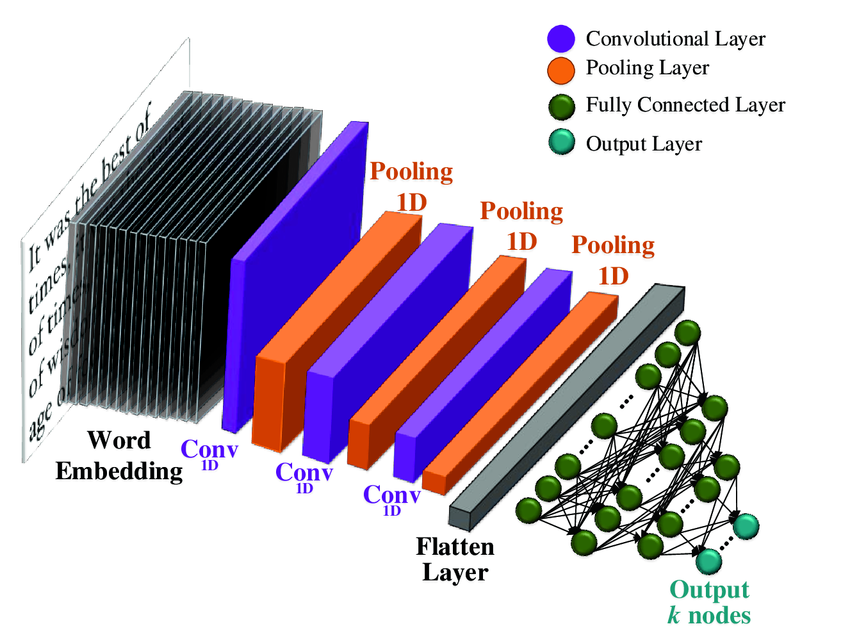

[link](https://www.vrogue.co/post/the-architecture-of-our-convolutional-neural-network-download-vrogue)

In [96]:
class FashionModelV2(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_layers: int = 10
                 , *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape,hidden_layers,3,1,1),
            nn.ReLU(),
            nn.Conv2d(hidden_layers, hidden_layers, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_layers,hidden_layers,3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_layers, hidden_layers, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_layers * 7 * 7, output_shape) #How to know this shape? Just print the shape
            #Of the vector in each transformation or just do the math
        )
    def forward(self, x:torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        #print(x.shape)
        return self.classifier(x)

model_2 = FashionModelV2(1, len(objects)).to(device)
model_2

FashionModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [97]:
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [98]:
torch.manual_seed(23)

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch + 1}------\n")
    train_func(model_2,train_data,loss_fn,optimizer,accuracy)
    test_func(model_2,train_data,loss_fn,optimizer,accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1------

torch.Size([64, 10, 7, 7])
Train loss:  0.00245 | Train accuracy  0.01166
torch.Size([64, 10, 7, 7])
Train loss:  0.00246 | Train accuracy  0.01334
torch.Size([64, 10, 7, 7])
Train loss:  0.00246 | Train accuracy  0.00501
torch.Size([64, 10, 7, 7])
Train loss:  0.00246 | Train accuracy  0.01167
torch.Size([64, 10, 7, 7])
Train loss:  0.00246 | Train accuracy  0.02000
torch.Size([64, 10, 7, 7])
Train loss:  0.00244 | Train accuracy  0.02001
torch.Size([64, 10, 7, 7])
Train loss:  0.00245 | Train accuracy  0.00835
torch.Size([64, 10, 7, 7])
Train loss:  0.00246 | Train accuracy  0.00834
torch.Size([64, 10, 7, 7])
Train loss:  0.00247 | Train accuracy  0.00334
torch.Size([64, 10, 7, 7])
Train loss:  0.00246 | Train accuracy  0.00334
torch.Size([64, 10, 7, 7])
Train loss:  0.00246 | Train accuracy  0.00833
torch.Size([64, 10, 7, 7])
Train loss:  0.00245 | Train accuracy  0.00834
torch.Size([64, 10, 7, 7])
Train loss:  0.00244 | Train accuracy  0.01334
torch.Size([64, 10, 7,

 10%|█         | 1/10 [00:16<02:24, 16.03s/it]

torch.Size([64, 10, 7, 7])
Train loss:  0.00034 | Train accuracy  0.09504
torch.Size([64, 10, 7, 7])
Train loss:  0.00060 | Train accuracy  0.08672
torch.Size([64, 10, 7, 7])
Train loss:  0.00053 | Train accuracy  0.09837
torch.Size([64, 10, 7, 7])
Train loss:  0.00068 | Train accuracy  0.07840
torch.Size([64, 10, 7, 7])
Train loss:  0.00065 | Train accuracy  0.08337
torch.Size([64, 10, 7, 7])
Train loss:  0.00048 | Train accuracy  0.09171
torch.Size([64, 10, 7, 7])
Train loss:  0.00061 | Train accuracy  0.08006
torch.Size([64, 10, 7, 7])
Train loss:  0.00052 | Train accuracy  0.08837
torch.Size([64, 10, 7, 7])
Train loss:  0.00060 | Train accuracy  0.08838
torch.Size([64, 10, 7, 7])
Train loss:  0.00054 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00055 | Train accuracy  0.09338
torch.Size([64, 10, 7, 7])
Train loss:  0.00041 | Train accuracy  0.09338
torch.Size([64, 10, 7, 7])
Train loss:  0.00049 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:

 20%|██        | 2/10 [00:28<01:49, 13.68s/it]

Train loss:  0.00039 | Train accuracy  0.09171
torch.Size([64, 10, 7, 7])
Train loss:  0.00046 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00048 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00033 | Train accuracy  0.09671
torch.Size([64, 10, 7, 7])
Train loss:  0.00046 | Train accuracy  0.08839
torch.Size([64, 10, 7, 7])
Train loss:  0.00059 | Train accuracy  0.08505
torch.Size([64, 10, 7, 7])
Train loss:  0.00043 | Train accuracy  0.09504
torch.Size([64, 10, 7, 7])
Train loss:  0.00044 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00034 | Train accuracy  0.09838
torch.Size([64, 10, 7, 7])
Train loss:  0.00055 | Train accuracy  0.08839
torch.Size([64, 10, 7, 7])
Train loss:  0.00049 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00032 | Train accuracy  0.09838
torch.Size([64, 10, 7, 7])
Train loss:  0.00038 | Train accuracy  0.09339
torch.Size([64, 10, 7, 7])
Train loss:  0.00038 | Train accuracy 

 30%|███       | 3/10 [00:40<01:30, 12.94s/it]

torch.Size([64, 10, 7, 7])
Train loss:  0.00032 | Train accuracy  0.09505
torch.Size([64, 10, 7, 7])
Train loss:  0.00031 | Train accuracy  0.09672
torch.Size([64, 10, 7, 7])
Train loss:  0.00020 | Train accuracy  0.10005
torch.Size([64, 10, 7, 7])
Train loss:  0.00021 | Train accuracy  0.10338
torch.Size([64, 10, 7, 7])
Train loss:  0.00043 | Train accuracy  0.09339
torch.Size([64, 10, 7, 7])
Train loss:  0.00043 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00043 | Train accuracy  0.09505
torch.Size([64, 10, 7, 7])
Train loss:  0.00041 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00030 | Train accuracy  0.09671
torch.Size([64, 10, 7, 7])
Train loss:  0.00025 | Train accuracy  0.09339
torch.Size([64, 10, 7, 7])
Train loss:  0.00023 | Train accuracy  0.10005
torch.Size([64, 10, 7, 7])
Train loss:  0.00043 | Train accuracy  0.09339
torch.Size([64, 10, 7, 7])
Train loss:  0.00051 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:

 40%|████      | 4/10 [00:52<01:15, 12.56s/it]

torch.Size([64, 10, 7, 7])
Train loss:  0.00022 | Train accuracy  0.10005
torch.Size([64, 10, 7, 7])
Train loss:  0.00044 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00035 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00048 | Train accuracy  0.08838
torch.Size([64, 10, 7, 7])
Train loss:  0.00024 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00050 | Train accuracy  0.08672
torch.Size([64, 10, 7, 7])
Train loss:  0.00042 | Train accuracy  0.09338
torch.Size([64, 10, 7, 7])
Train loss:  0.00045 | Train accuracy  0.08839
torch.Size([64, 10, 7, 7])
Train loss:  0.00044 | Train accuracy  0.08505
torch.Size([64, 10, 7, 7])
Train loss:  0.00044 | Train accuracy  0.09337
torch.Size([64, 10, 7, 7])
Train loss:  0.00037 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00038 | Train accuracy  0.09338
torch.Size([64, 10, 7, 7])
Train loss:  0.00044 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:

 50%|█████     | 5/10 [01:04<01:02, 12.41s/it]

torch.Size([64, 10, 7, 7])
Train loss:  0.00042 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00072 | Train accuracy  0.08172
torch.Size([64, 10, 7, 7])
Train loss:  0.00033 | Train accuracy  0.09837
torch.Size([64, 10, 7, 7])
Train loss:  0.00029 | Train accuracy  0.09339
torch.Size([64, 10, 7, 7])
Train loss:  0.00041 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00030 | Train accuracy  0.09671
torch.Size([64, 10, 7, 7])
Train loss:  0.00072 | Train accuracy  0.08506
torch.Size([64, 10, 7, 7])
Train loss:  0.00050 | Train accuracy  0.09171
torch.Size([64, 10, 7, 7])
Train loss:  0.00034 | Train accuracy  0.09338
torch.Size([64, 10, 7, 7])
Train loss:  0.00053 | Train accuracy  0.08839
torch.Size([64, 10, 7, 7])
Train loss:  0.00057 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00056 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00045 | Train accuracy  0.09671
torch.Size([64, 10, 7, 7])
Train loss:

 60%|██████    | 6/10 [01:16<00:49, 12.38s/it]

torch.Size([64, 10, 7, 7])
Train loss:  0.00017 | Train accuracy  0.09838
torch.Size([64, 10, 7, 7])
Train loss:  0.00025 | Train accuracy  0.09839
torch.Size([64, 10, 7, 7])
Train loss:  0.00036 | Train accuracy  0.09339
torch.Size([64, 10, 7, 7])
Train loss:  0.00031 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00048 | Train accuracy  0.09338
torch.Size([64, 10, 7, 7])
Train loss:  0.00018 | Train accuracy  0.10005
torch.Size([64, 10, 7, 7])
Train loss:  0.00024 | Train accuracy  0.10338
torch.Size([64, 10, 7, 7])
Train loss:  0.00024 | Train accuracy  0.09339
torch.Size([64, 10, 7, 7])
Train loss:  0.00026 | Train accuracy  0.09505
torch.Size([64, 10, 7, 7])
Train loss:  0.00031 | Train accuracy  0.10005
torch.Size([64, 10, 7, 7])
Train loss:  0.00033 | Train accuracy  0.09672
torch.Size([64, 10, 7, 7])
Train loss:  0.00020 | Train accuracy  0.09838
torch.Size([64, 10, 7, 7])
Train loss:  0.00032 | Train accuracy  0.09672
torch.Size([32, 10, 7, 7])
Train loss:

 70%|███████   | 7/10 [01:28<00:36, 12.31s/it]

torch.Size([64, 10, 7, 7])
Train loss:  0.00022 | Train accuracy  0.09839
torch.Size([64, 10, 7, 7])
Train loss:  0.00044 | Train accuracy  0.09339
torch.Size([64, 10, 7, 7])
Train loss:  0.00060 | Train accuracy  0.08505
torch.Size([64, 10, 7, 7])
Train loss:  0.00025 | Train accuracy  0.09504
torch.Size([64, 10, 7, 7])
Train loss:  0.00026 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00017 | Train accuracy  0.09838
torch.Size([64, 10, 7, 7])
Train loss:  0.00039 | Train accuracy  0.08839
torch.Size([64, 10, 7, 7])
Train loss:  0.00035 | Train accuracy  0.09504
torch.Size([64, 10, 7, 7])
Train loss:  0.00042 | Train accuracy  0.09338
torch.Size([32, 10, 7, 7])
Train loss:  0.00017 | Train accuracy  0.10005
Epoch: 8------

torch.Size([64, 10, 7, 7])
Train loss:  0.00061 | Train accuracy  0.08329
torch.Size([64, 10, 7, 7])
Train loss:  0.00048 | Train accuracy  0.09004
torch.Size([64, 10, 7, 7])
Train loss:  0.00044 | Train accuracy  0.09171
torch.Size([64, 10, 7,

 80%|████████  | 8/10 [01:40<00:24, 12.26s/it]

torch.Size([64, 10, 7, 7])
Train loss:  0.00027 | Train accuracy  0.09838
torch.Size([64, 10, 7, 7])
Train loss:  0.00030 | Train accuracy  0.10172
torch.Size([64, 10, 7, 7])
Train loss:  0.00024 | Train accuracy  0.09839
torch.Size([64, 10, 7, 7])
Train loss:  0.00046 | Train accuracy  0.09339
torch.Size([64, 10, 7, 7])
Train loss:  0.00045 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00019 | Train accuracy  0.09671
torch.Size([64, 10, 7, 7])
Train loss:  0.00050 | Train accuracy  0.09006
torch.Size([64, 10, 7, 7])
Train loss:  0.00025 | Train accuracy  0.09671
torch.Size([64, 10, 7, 7])
Train loss:  0.00019 | Train accuracy  0.10172
torch.Size([64, 10, 7, 7])
Train loss:  0.00033 | Train accuracy  0.08839
torch.Size([64, 10, 7, 7])
Train loss:  0.00024 | Train accuracy  0.10004
torch.Size([64, 10, 7, 7])
Train loss:  0.00038 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00021 | Train accuracy  0.09838
torch.Size([32, 10, 7, 7])
Train loss:

 90%|█████████ | 9/10 [01:53<00:12, 12.23s/it]

torch.Size([64, 10, 7, 7])
Train loss:  0.00031 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00025 | Train accuracy  0.09838
torch.Size([64, 10, 7, 7])
Train loss:  0.00051 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00048 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00036 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00040 | Train accuracy  0.09505
torch.Size([64, 10, 7, 7])
Train loss:  0.00023 | Train accuracy  0.10005
torch.Size([64, 10, 7, 7])
Train loss:  0.00037 | Train accuracy  0.09172
torch.Size([64, 10, 7, 7])
Train loss:  0.00028 | Train accuracy  0.09671
torch.Size([64, 10, 7, 7])
Train loss:  0.00028 | Train accuracy  0.09505
torch.Size([64, 10, 7, 7])
Train loss:  0.00034 | Train accuracy  0.09505
torch.Size([64, 10, 7, 7])
Train loss:  0.00047 | Train accuracy  0.09005
torch.Size([64, 10, 7, 7])
Train loss:  0.00013 | Train accuracy  0.10171
torch.Size([64, 10, 7, 7])
Train loss:

100%|██████████| 10/10 [02:05<00:00, 12.53s/it]

torch.Size([64, 10, 7, 7])
Train loss:  0.00030 | Train accuracy  0.09671
torch.Size([64, 10, 7, 7])
Train loss:  0.00042 | Train accuracy  0.09006
torch.Size([64, 10, 7, 7])
Train loss:  0.00039 | Train accuracy  0.09671
torch.Size([64, 10, 7, 7])
Train loss:  0.00050 | Train accuracy  0.08839
torch.Size([64, 10, 7, 7])
Train loss:  0.00026 | Train accuracy  0.09838
torch.Size([64, 10, 7, 7])
Train loss:  0.00061 | Train accuracy  0.08506
torch.Size([64, 10, 7, 7])
Train loss:  0.00019 | Train accuracy  0.10170
torch.Size([64, 10, 7, 7])
Train loss:  0.00018 | Train accuracy  0.10172
torch.Size([64, 10, 7, 7])
Train loss:  0.00034 | Train accuracy  0.09506
torch.Size([64, 10, 7, 7])
Train loss:  0.00021 | Train accuracy  0.09505
torch.Size([64, 10, 7, 7])
Train loss:  0.00021 | Train accuracy  0.09838
torch.Size([64, 10, 7, 7])
Train loss:  0.00024 | Train accuracy  0.09839
torch.Size([64, 10, 7, 7])
Train loss:  0.00014 | Train accuracy  0.10338
torch.Size([64, 10, 7, 7])
Train loss:

In [123]:
model_2.eval()
y_preds = []
y_true = []
with torch.inference_mode():
    for X, y in tqdm(test_data, desc= "Making predicts"):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit, 1).argmax(1)
        y_preds.append(y_pred.cpu())
        y_true.append(y.cpu())
y_pred_tesor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)

Making predicts:  36%|███▋      | 57/157 [00:00<00:00, 283.06it/s]

torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
t

Making predicts:  55%|█████▌    | 87/157 [00:00<00:00, 288.36it/s]

torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
t

Making predicts: 100%|██████████| 157/157 [00:00<00:00, 275.87it/s]

torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
torch.Size([64, 10, 7, 7])
t

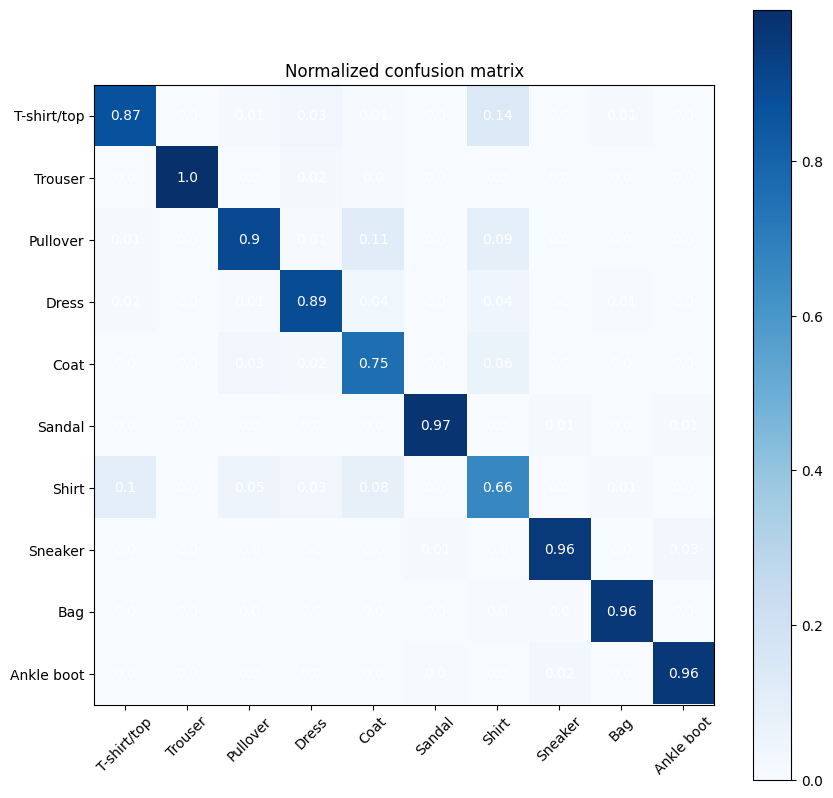

In [125]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true_tensor, y_pred_tesor)
cm = cm / np.sum(cm,axis=0) # to normalize
cmap = plt.cm.Blues
tick_marks = np.arange(10)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, np.around(cm[i, j],decimals=2),
                       ha="center", va="center", color="w")
plt.title('Normalized confusion matrix')
fig.colorbar(im)
plt.xticks(tick_marks, objects, rotation=45)
plt.yticks(tick_marks, objects);

In [131]:
eval_model(model_2, test_data, loss_fn, accuracy)

torch.Size([64, 10, 7, 7])


{'model_name': 'FashionModelV2',
 'model_loss': 0.002584900939837098,
 'model_acc': tensor(0.5474, device='cuda:0')}

In [126]:
torch.save(model_2.state_dict(), "../models/FashionMNIST.pth")

But what is doing the conv2d layer? Remember how a convolutions layer works, it makes a kernel with the parameters that you enter, and then pass all the matrix geeing one value in the kernel size

In [3]:
example_tensor = torch.rand(size=(32,  789, 28, 28))
print(example_tensor.shape)
conv_layer = nn.Conv2d(
    789,
    10,
    3,
    1,
    0
)
print(conv_layer(example_tensor).shape)

torch.Size([32, 789, 28, 28])
torch.Size([32, 10, 26, 26])


So it compress the information from the data